# Installing and loading packages

In [1]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.6 MB/s eta 0:00:00


In [103]:
from datasets import load_dataset
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from networkx.algorithms.components.connected import is_connected
from collections import Counter
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", message="The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.")

In [3]:
dataset = load_dataset('graphs-datasets/reddit_threads')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating full split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/graphs-datasets___parquet/graphs-datasets--reddit_threads-504bb5aea09f16e5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

# Checking two-sided edges

In [ ]:
# Function to check if all edges in a graph are two-sided
def check_two_sided_edges(graph):
    for u, v in graph.edges():
        if not graph.has_edge(v, u):
            return False
    return True

In [52]:
# Storing dataset length in a variable
DATASET_LEN = len(dataset['full'])

In [ ]:
# Creating an empty list to store results
all_edges_two_sided = []

# Looping through the dataset
for i in range(0,DATASET_LEN):
  
    #Extracting data
    row_edges = dataset['full'][i]['edge_index']

    # Create an empty graph
    graph = nx.DiGraph()

    # Check if all edges are two-sided
    all_two_sided = check_two_sided_edges(graph)

    # Print the result
    if all_two_sided:
        all_edges_two_sided.append('1')
    else:
        all_edges_two_sided.append('0')

print('Number of graphs which have one-sided edges is', all_edges_two_sided.count(0))

# Converting rows into graphs and calculating number of edges in a graph

In [87]:
%%time 
## This cell takes around 2 -3 min for the whole dataset

# Making an empty list to store the graphs
graph_list = []   

# Looping through the dataset
for i in range(0,DATASET_LEN):

    #Extracting data
    row_edges = dataset['full'][i]['edge_index']
    row_label = dataset['full'][i]['y']
    row_node_numbers = dataset['full'][i]['num_nodes']

    # Create an empty graph
    graph = nx.Graph()

    # Add edges from the data
    if len(row_edges[0]) == len(row_edges[1]):
      edges = zip(row_edges[0], row_edges[1])
      graph.add_edges_from(edges)

    # Add network-level feature to the graph
    graph.graph['label'] = row_label[0]
    if row_node_numbers != graph.number_of_nodes():
      print('Warning: number of nodes of the graph and the provided feature does not match on row ', i, '!')
    graph.graph['num_nodes'] = row_node_numbers
    graph.graph['num_edges'] = graph.number_of_edges()

    # Add graph to the list of graphs
    graph_list.append(graph)

CPU times: user 2min 11s, sys: 5.15 s, total: 2min 16s
Wall time: 2min 38s


In [ ]:
#Sidenote on how to access nodes, edges, features
sorted(graph_list[0].nodes), sorted(graph_list[0].edges), graph_list[0].graph['label'], graph_list[0].graph['num_nodes'], graph_list[0].graph['num_edges']

# Calculating the features of a network and storing it in a pandas dataframe

In [ ]:
%%time
## Took 2h 7min 45s for the whole dataset!!
# Create an empty DataFrame
df = pd.DataFrame(columns=['edge_list', 'label', 'num_edges', 'num_nodes', 'density', 'is_connected', 'nr_connected_components', 
                           'average_path_length', 'diameter', 'clustering_coefficient', 'assortativity', #'modularity_greedy_mod', 
                           'modularity_label_prop', 'modularity_girvan_newman', 'degrees', 'degree_probabilities'])

# Iterate over each graph in the data list
for graph in graph_list:

    # Calculate communities in a graph
    #communities_greedy_mod = nx.algorithms.community.modularity_max.naive_greedy_modularity_communities(graph) # <--- Takes exessively long time to calculate, so do not use for big dataset
                                                                              # Find communities in G using greedy modularity maximization.
                                                                              # Greedy modularity maximization begins with each node in its own community 
                                                                              # and joins the pair of communities that most increases modularity until no such pair exists.

    communities_label_prop = nx.algorithms.community.label_propagation.label_propagation_communities(graph)
                                                                              # Generates community sets determined by label propagation
                                                                              # Finds communities in G using a semi-synchronous label propagation method [1].
    
    for c in (nx.algorithms.community.centrality.girvan_newman(graph)):       # The Girvan–Newman algorithm detects communities by progressively removing edges from the original graph. 
        communities_girvan_newman = c                                         # The algorithm removes the “most valuable” edge, 
        if len(c) == 5:                                                       # traditionally the edge with the highest betweenness centrality, at each step. 
            break

    # Calculate degrees of all nodes
    degrees = dict(graph.degree())

    # Count degree frequencies
    degree_counts = dict(Counter(degrees.values()))

    # Calculate the total number of nodes
    total_nodes = len(graph.nodes)

    # Calculate the probability distribution
    probability_list = [count / total_nodes for count in degree_counts.values()]

    # Store degrees and frequencies in separate lists
    degree_list = list(degree_counts.keys())
    probability_list = list(probability_list)


    # Append the graph data to the DataFrame
    df = df.append({
        'edge_list': sorted(graph.edges),
        'label': graph.graph['label'],
        'num_edges': graph.graph['num_edges'],
        'num_nodes': graph.graph['num_nodes'],
        'density' : nx.density(graph),                                        # DENSITY - the density is 0 for a graph without edges and 1 for a complete graph.
        'is_connected' : nx.is_connected(graph),                              # returns True if the graph is connected
        'nr_connected_components' : nx.number_connected_components(graph),    # returns the number of connected components
        'average_path_length' : nx.average_shortest_path_length(graph),       # AVERAGE PATH LENGTH - the fewest number of edges that you would have to go on to get from one node to another degrees of separation
        'diameter' : nx.diameter(graph),                                      # DIAMETER - maximum path length        
        'clustering_coefficient' : nx.average_clustering(graph),              # CLUSTERING COEFFICIENT - measure of the degree to which nodes in a graph tend to cluster together. 
                                                                                  # If the neighborhood is fully connected, the clustering coefficient is 1 and a value close to 0 means that there are hardly any connections in the neighborhood.
                    
        'assortativity' : nx.degree_assortativity_coefficient(graph),          # ASSORTATIVITY - measures the tendency of nodes in a network to connect to other nodes with similar attributes or degrees
                                                                                  # Assortativity coefficient ranges from -1 to 1. A positive assortativity coefficient indicates assortative mixing, 
                                                                                  # meaning that nodes with similar degrees tend to connect to each other. 
                                                                                  # A negative assortativity coefficient indicates disassortative mixing, where nodes with different degrees are more likely to connect. 
                                                                                  # A value close to 0 suggests a network with no clear assortative or disassortative mixing pattern.
                    
        #'modularity_greedy_mod' : nx.algorithms.community.modularity(graph, communities_greedy_mod),                                                                                
        'modularity_label_prop' : nx.algorithms.community.modularity(graph, communities_label_prop),
        'modularity_girvan_newman' : nx.algorithms.community.modularity(graph, communities_girvan_newman),
                                                                              # MODULARITY - measure of the strength of community structure in a network.
                                                                                  # Values range from -1 to 1, where higher values indicate stronger community structure within the network.
        'degrees' : degree_list,
        'degree_probabilities' : probability_list

    }, ignore_index=True)
    # Convert 'Degree' column to numeric
    df['is_connected'] = df['is_connected'].astype(bool)

CPU times: user 2h 5min 15s, sys: 1min 39s, total: 2h 6min 54s
Wall time: 2h 7min 45s


In [44]:
# Alternative way to already access the calculated data
# Load the csv data into a DataFrame

#### df = pd.read_csv('graph_data_full.csv')

# Analysis on the data

In [51]:
#Checking if data contains null values
df.isnull().sum()

edge_list                   0
label                       0
num_edges                   0
num_nodes                   0
density                     0
is_connected                0
nr_connected_components     0
average_path_length         0
diameter                    0
clustering_coefficient      0
assortativity               0
modularity_label_prop       0
modularity_girvan_newman    0
degrees                     0
degree_probabilities        0
dtype: int64

In [66]:
# Checking if all the graphs are connected
df['is_connected'].value_counts().to_frame()

,is_connected
True,203088


In [65]:
# Checking number of components in the graphs
df['nr_connected_components'].value_counts().to_frame()

,nr_connected_components
1,203088


In [72]:
# Checking is our data balanced in terms of the label
df['label'].value_counts().to_frame()

,label
1,104065
0,99023


In [67]:
# Get some sense of the whole data with describe function
df.describe(include="all")

,edge_list,label,num_edges,num_nodes,density,is_connected,nr_connected_components,average_path_length,diameter,clustering_coefficient,assortativity,modularity_label_prop,modularity_girvan_newman,degrees,degree_probabilities
count,203088,203088.000000,203088.000000,203088.000000,203088.000000,203088,203088.0,203088.000000,203088.000000,203088.000000,203088.000000,203088.000000,203088.000000,203088,203088
unique,175051,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39002,57017
top,"[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6...",NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[1, 10, 2]","[0.8333333333333334, 0.08333333333333333, 0.08..."
freq,422,NaN,NaN,NaN,NaN,203088,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5927,3722
mean,NaN,0.512413,24.851375,23.926968,0.117135,NaN,1.0,2.427850,4.578065,0.046727,-0.654529,0.255165,0.263210,NaN,NaN
std,NaN,0.499847,19.143689,16.554645,0.048414,NaN,0.0,0.653612,2.171184,0.069778,0.216767,0.174359,0.192136,NaN,NaN
min,NaN,0.000000,10.000000,11.000000,0.020619,NaN,1.0,1.690909,2.000000,0.000000,-1.000000,0.000000,-0.053633,NaN,NaN
25%,NaN,0.000000,13.000000,13.000000,0.078818,NaN,1.0,1.983333,3.000000,0.000000,-0.829268,0.119898,0.083333,NaN,NaN
50%,NaN,1.000000,17.000000,17.000000,0.117647,NaN,1.0,2.213333,4.000000,0.000000,-0.672453,0.252066,0.258264,NaN,NaN
75%,NaN,1.000000,28.000000,27.000000,0.153846,NaN,1.0,2.641653,5.000000,0.082332,-0.492248,0.398438,0.410494,NaN,NaN


In [83]:
# Looking specifically the labels with 0
df[df['label']==0][['num_edges', 'num_nodes', 'diameter', 'average_path_length', 'assortativity', 'modularity_label_prop', 'modularity_girvan_newman']].describe()

,num_edges,num_nodes,diameter,average_path_length,assortativity,modularity_label_prop,modularity_girvan_newman
count,99023.000000,99023.000000,99023.000000,99023.000000,99023.000000,99023.000000,99023.000000
mean,30.369369,28.721701,5.682003,2.756091,-0.535471,0.356237,0.374610
std,22.544754,19.451506,2.364806,0.750552,0.199061,0.154875,0.172590
min,10.000000,11.000000,2.000000,1.743590,-1.000000,0.000000,-0.050000
25%,14.000000,15.000000,4.000000,2.241704,-0.671865,0.258739,0.263889
50%,22.000000,21.000000,5.000000,2.586895,-0.520891,0.384444,0.392734
75%,38.000000,36.000000,7.000000,3.064309,-0.387637,0.473140,0.505178
max,185.000000,97.000000,27.000000,9.860362,0.315789,0.703316,0.750434


In [84]:
# Looking specifically the labels with 1
df[df['label']==1][['diameter', 'num_edges', 'num_nodes', 'average_path_length', 'assortativity', 'modularity_label_prop', 'modularity_girvan_newman']].describe()

,diameter,num_edges,num_nodes,average_path_length,assortativity,modularity_label_prop,modularity_girvan_newman
count,104065.000000,104065.00000,104065.000000,104065.000000,104065.000000,1.040650e+05,104065.000000
mean,3.527613,19.60073,19.364541,2.115513,-0.767818,1.589897e-01,0.157207
std,1.270931,13.22974,11.494171,0.312426,0.166348,1.324198e-01,0.143718
min,2.000000,10.00000,11.000000,1.690909,-1.000000,0.000000e+00,-0.053633
25%,3.000000,12.00000,13.000000,1.954545,-0.883089,1.110223e-16,0.072022
50%,3.000000,15.00000,15.000000,2.058824,-0.785172,1.446281e-01,0.155709
75%,4.000000,21.00000,21.000000,2.209524,-0.665109,2.520661e-01,0.258065
max,23.000000,177.00000,97.000000,9.140541,0.145716,6.881060e-01,0.739004


# Visualizing the graphs

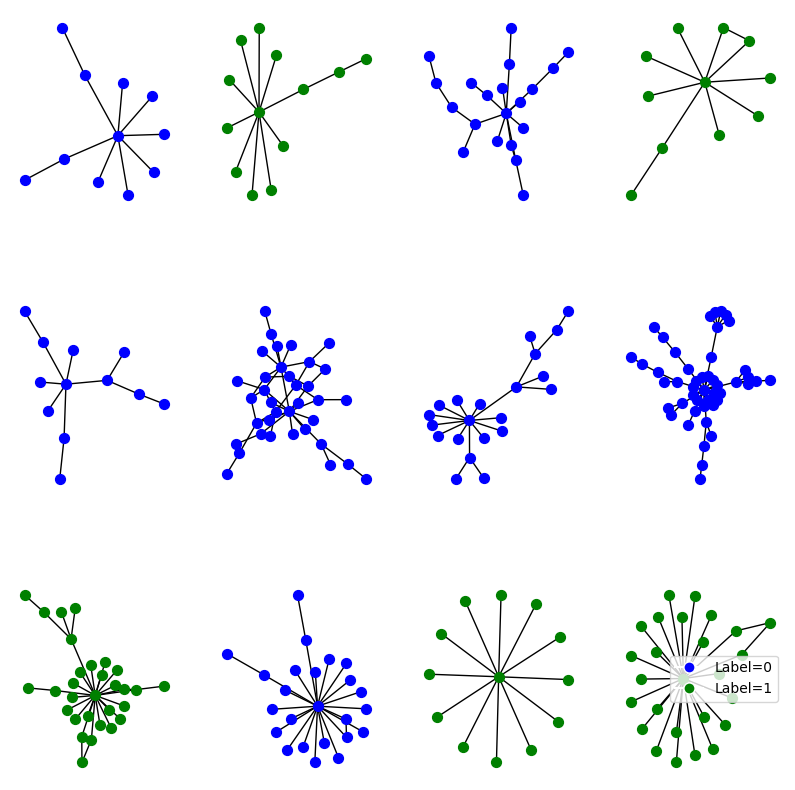

In [102]:
# Only display the first 12 graphs
num_graphs_to_display = 12
graphs_to_display = graph_list[:num_graphs_to_display]

# Calculate the number of rows and columns for the subplots
num_graphs = len(graphs_to_display)
rows = int(num_graphs ** 0.5)
cols = (num_graphs // rows) + (num_graphs % rows > 0)

# Create a color map for the labels
label_color_map = {0: 'blue', 1: 'green'}

# Create the subplots
fig, axs = plt.subplots(rows, cols, figsize=(10, 10))

# Iterate over the graphs to display on separate subplots
for i, graph in enumerate(graphs_to_display):
    row = i // cols
    col = i % cols

    # Get the label of the graph
    label = graph.graph.get('label')
    
    # Get the color based on the label
    color = label_color_map.get(label)
    nx.draw(graph, ax=axs[row, col], node_size=50, node_color=color)

# Hide any empty subplots
for i in range(num_graphs, rows * cols):
    axs[i // cols, i % cols].axis('off')

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='Label=0',
                              markerfacecolor='blue', markersize=8),
                   plt.Line2D([0], [0], marker='o', color='w', label='Label=1',
                              markerfacecolor='green', markersize=8)]

# Add the legend to the plot
plt.legend(handles=legend_elements)

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()

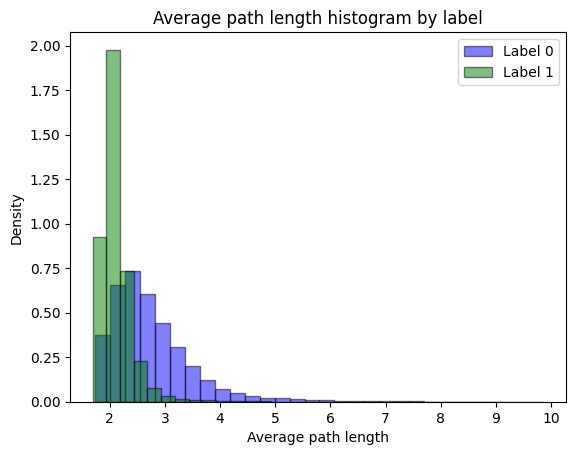

In [111]:
## Visualizing average path length between two labels, the histogram is normalized to take into account the label distribution
# Filter the DataFrame for label 0
label_0 = df[df['label'] == 0]['average_path_length']

# Filter the DataFrame for label 1
label_1 = df[df['label'] == 1]['average_path_length']

# Create histograms for each label category
plt.hist(label_0, bins=30, edgecolor='black', alpha=0.5, label='Label 0', color = 'blue', density=True)
plt.hist(label_1, bins=30, edgecolor='black', alpha=0.5, label='Label 1', color='green', density=True)

# Set the title and labels
plt.title('Average path length histogram by label')
plt.xlabel('Average path length')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

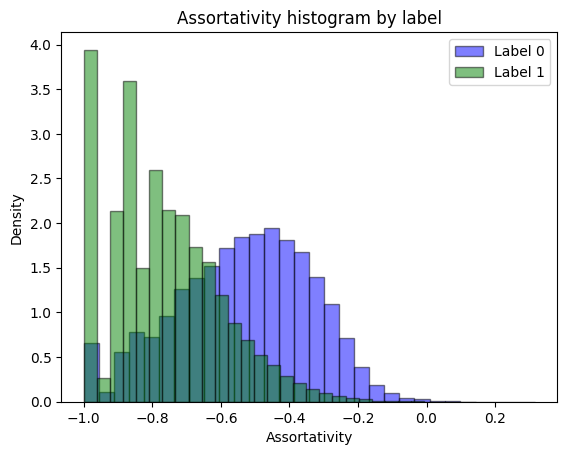

In [112]:
## Visualizing assortativity between two labels, the histogram is normalized to take into account the label distribution
# Filter the DataFrame for label 0
label_0 = df[df['label'] == 0]['assortativity']

# Filter the DataFrame for label 1
label_1 = df[df['label'] == 1]['assortativity']

# Create histograms for each label category
plt.hist(label_0, bins=30, edgecolor='black', alpha=0.5, label='Label 0', color = 'blue', density=True)
plt.hist(label_1, bins=30, edgecolor='black', alpha=0.5, label='Label 1', color='green', density=True)

# Set the title and labels
plt.title('Assortativity histogram by label')
plt.xlabel('Assortativity')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

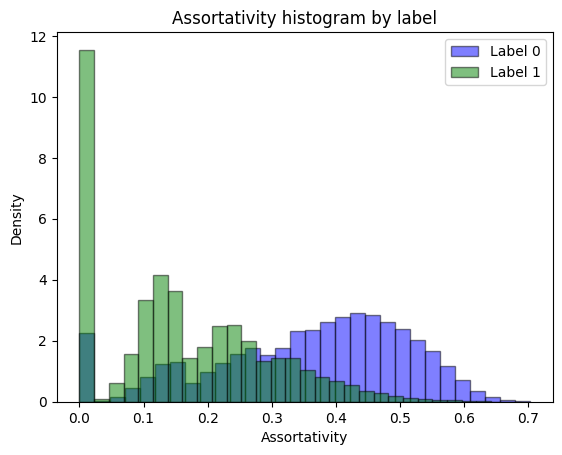

In [113]:
## Visualizing modularity between two labels, the histogram is normalized to take into account the label distribution
# Filter the DataFrame for label 0
label_0 = df[df['label'] == 0]['modularity_label_prop']

# Filter the DataFrame for label 1
label_1 = df[df['label'] == 1]['modularity_label_prop']

# Create histograms for each label category
plt.hist(label_0, bins=30, edgecolor='black', alpha=0.5, label='Label 0', color = 'blue', density=True)
plt.hist(label_1, bins=30, edgecolor='black', alpha=0.5, label='Label 1', color='green', density=True)

# Set the title and labels
plt.title('Modularity histogram by label')
plt.xlabel('Modularity')
plt.ylabel('Density')

# Add a legend
plt.legend()

# Show the plot
plt.show()

# Degree distribution

Optimization terminated successfully.
         Current function value: 0.372917
         Iterations 8


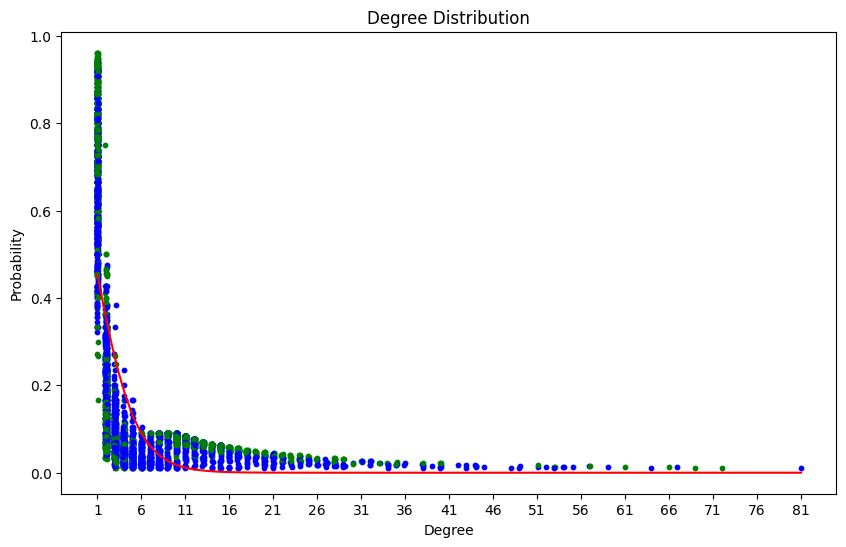

In [ ]:
##Degree distribution for all the data

# Create a wider figure
plt.figure(figsize=(10, 6))  # Adjust the width (10) and height (6) as desired

# Loop through all rows in the DataFrame
for index, row in df.iterrows():
    degree_list = row['degrees']
    probability_list = row['degree_probabilities']
    label = row['label']

    # Add random jitter to x-coordinates
    jitter = 0.1  # Adjust the jitter factor as desired
    degree_jitter = [degree + np.random.uniform(-jitter, jitter) for degree in degree_list]

    # Set color based on label value
    color = 'blue' if label == 0 else 'green'

    # Plot the degree distribution with jitter and color
    plt.scatter(degree_jitter, probability_list, color=color, s=10)

# Combine all degree and probability values
degree_list_all = np.concatenate(df['degrees'].values)
probability_list_all = np.concatenate(df['degree_probabilities'].values)

# Fit the logistic regression model
X = sm.add_constant(degree_list_all)
logit_model = sm.Logit(probability_list_all, X)
logit_result = logit_model.fit()

# Generate x-values for the regression line
line_x = np.linspace(min(degree_list_all), max(degree_list_all), 100)

# Predict the probability using the logistic regression model
X_line = sm.add_constant(line_x)
line_y = logit_result.predict(X_line)

# Plot the logistic regression line
plt.plot(line_x, line_y, color='red')

# Customize the plot
plt.xlabel('Degree')
plt.ylabel('Probability')
plt.title('Degree Distribution')

# Set x-axis ticks
plt.xticks(np.arange(min(degree_list_all), max(degree_list_all) + 1, 5))  # Adjust the tick range (2) as desired

# Display the plot
plt.show()

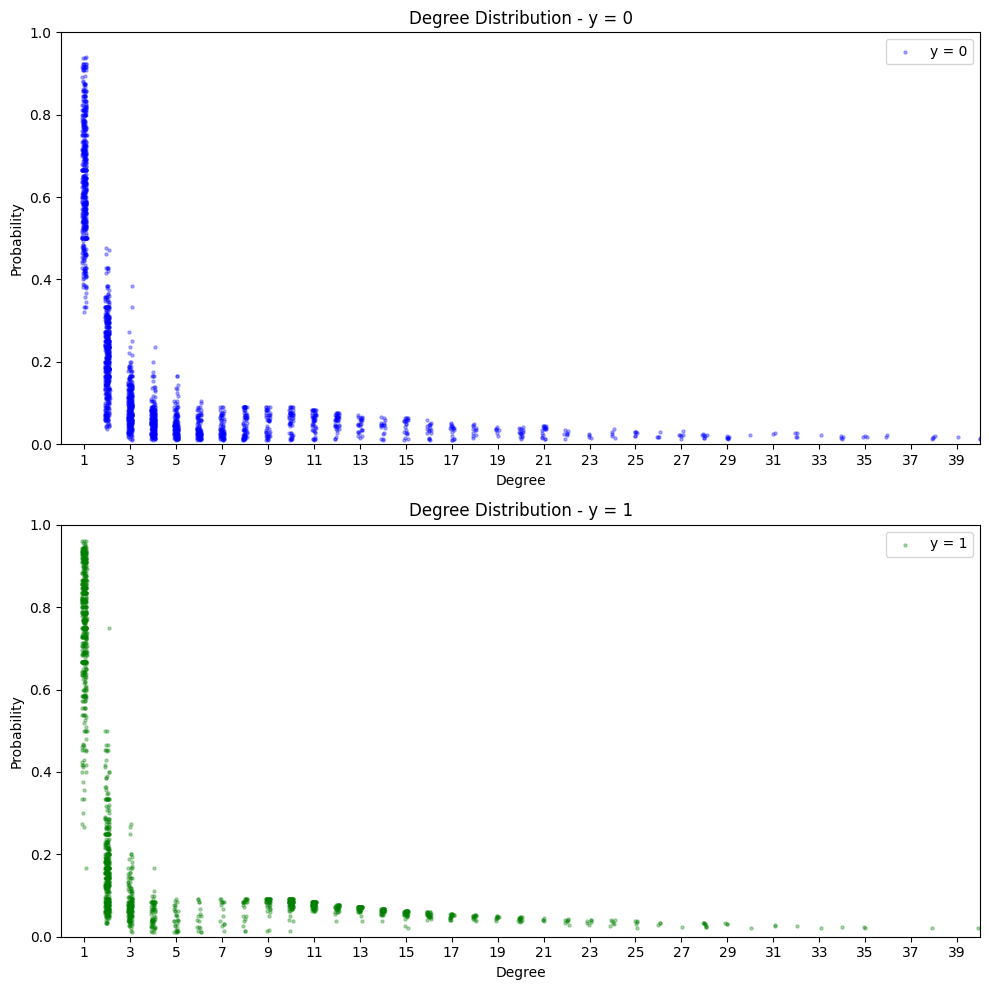

CPU times: user 704 ms, sys: 132 ms, total: 836 ms
Wall time: 711 ms


In [ ]:
%%time
##DEGREE DISTRIBUTIOn FOR BOTH LABELS SEPARATELY

# Create a wider figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))  # Adjust the width (10) and height (12) as desired

# Filter the DataFrame based on label = 0 and label = 1
df_label0 = df[df['label'] == 0]
df_label1 = df[df['label'] == 1]

# Extract degrees and degree probabilities for label = 0
degrees_label0 = np.concatenate(df_label0['degrees'].values)
degree_probabilities_label0 = np.concatenate(df_label0['degree_probabilities'].values)

# Extract degrees and degree probabilities for label = 1
degrees_label1 = np.concatenate(df_label1['degrees'].values)
degree_probabilities_label1 = np.concatenate(df_label1['degree_probabilities'].values)

# Add random jitter to x-coordinates
jitter = 0.1  # Adjust the jitter factor as desired
degree_jitter_label0 = [degree + np.random.uniform(-jitter, jitter) for degree in degrees_label0]
degree_jitter_label1 = [degree + np.random.uniform(-jitter, jitter) for degree in degrees_label1]

# Plot the degree distribution with jitter and color for label = 0 on the first subplot
axes[0].scatter(degree_jitter_label0, degree_probabilities_label0, color='blue', s=5, alpha=0.3, label='y = 0')

# Plot the degree distribution with jitter and color for label = 1 on the second subplot
axes[1].scatter(degree_jitter_label1, degree_probabilities_label1, color='green', s=5, alpha=0.3, label='y = 1')

# Customize the plots
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('Degree Distribution - y = 0')
axes[0].legend()
axes[0].set_xlim(0, 40)
axes[0].set_ylim(0.0, 1.0)

axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Degree Distribution - y = 1')
axes[1].legend()
axes[1].set_xlim(0, 40)
axes[1].set_ylim(0.0, 1.0)

# Set x-axis ticks for both subplots
min_degree = min(min(degrees_label0), min(degrees_label1))
max_degree = max(max(degrees_label0), max(degrees_label1))
axes[0].set_xticks(np.arange(min_degree, max_degree - 40, 2))  # Adjust the tick range (2) as desired
axes[1].set_xticks(np.arange(min_degree, max_degree - 40, 2))  # Adjust the tick range (2) as desired

# Display the plot
plt.tight_layout()
plt.show()


# Exporting data

In [ ]:
# Making a copy
df_ = df.copy(deep=True)

In [ ]:
# Dropping some data
df_.drop(columns=['is_connected', 'nr_connected_components', 'degrees', 'degree_probabilities'])

In [ ]:
# Save the DataFrame to a CSV file
df_.to_csv('graph_data.csv', index=False)